# Tugas Praktikum Mandiri — SVM Breast Cancer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Mounted at /content/drive


## --- Load dataset ---

In [2]:
csv_path = '/content/drive/MyDrive/praktikum_ml/praktikum06/data/Breast_cancer_dataset.csv'
df = pd.read_csv(csv_path)
print("Loaded:", csv_path)
print("Columns:", df.columns.tolist())

Loaded: /content/drive/MyDrive/praktikum_ml/praktikum06/data/Breast_cancer_dataset.csv
Columns: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']


## --- Basic cleaning/mapping ---

In [3]:
if 'id' in df.columns:
    df = df.drop(columns=['id'])
if 'diagnosis' not in df.columns:
    raise RuntimeError("Kolom 'diagnosis' tidak ditemukan.")
if df['diagnosis'].dtype == 'object':
    df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
if df['diagnosis'].isna().any():
    raise RuntimeError("Kolom 'diagnosis' berisi nilai selain 'M'/'B' setelah mapping.")

## --- Inspect missing values ---

In [4]:
print("\nMissing values (per column):")
missing = df.isna().sum().sort_values(ascending=False)
print(missing[missing > 0])

# show up to 10 rows that contain any NaN (if exist)
if df.isna().any().any():
    print("\nContoh baris dengan NaN:")
    display(df[df.isna().any(axis=1)].head(10))


Missing values (per column):
Unnamed: 32    569
dtype: int64

Contoh baris dengan NaN:


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,1,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,1,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,1,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,1,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,1,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


## --- Features / labels ---

In [5]:
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

## --- Train/test split ---

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"\nTrain size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (398, 31), Test size: (171, 31)


## --- Strategy decision ---

In [7]:
# If there are many columns with a lot of missing values, consider dropping columns:
cols_with_many_nans = (X_train.isna().mean() > 0.3)  # threshold 30%
if cols_with_many_nans.any():
    drop_cols = cols_with_many_nans[cols_with_many_nans].index.tolist()
    print("\nColumns with >30% NaN (dropping):", drop_cols)
    X_train = X_train.drop(columns=drop_cols)
    X_test = X_test.drop(columns=drop_cols)


Columns with >30% NaN (dropping): ['Unnamed: 32']


## --- Build pipeline: Imputer -> Scaler -> SVM ---

In [8]:
pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),   # impute numeric features with mean
    StandardScaler(),                 # scale features
    SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
)

## --- Train ---


In [9]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=42))])

## --- Predict & Evaluate ---

In [10]:
y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Benign(0)', 'Malignant(1)'])

print(f"\nAkurasi: {acc:.4f}\n")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)


Akurasi: 0.9591

Confusion Matrix:
 [[107   0]
 [  7  57]]

Classification Report:
               precision    recall  f1-score   support

   Benign(0)       0.94      1.00      0.97       107
Malignant(1)       1.00      0.89      0.94        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



## --- Plot confusion matrix ---

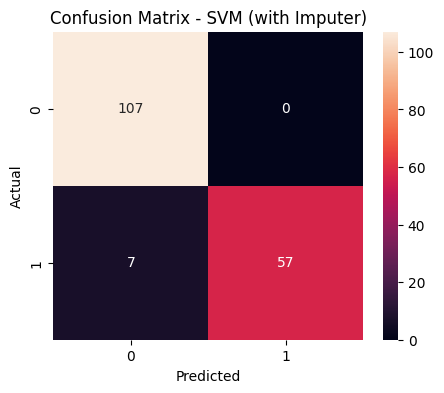

In [11]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix - SVM (with Imputer)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [12]:
import joblib

# Simpan model pipeline (imputer + scaler + SVM)
model_path = '/content/drive/MyDrive/praktikum_ml/praktikum06/model/svm_breast_cancer.pkl'
joblib.dump(pipeline, model_path)

print(f"✅ Model berhasil disimpan di: {model_path}")

✅ Model berhasil disimpan di: /content/drive/MyDrive/praktikum_ml/praktikum06/model/svm_breast_cancer.pkl
